In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os

In [117]:

# get file from parent directory
os.getcwd()
dir_path = os.getcwd() + "\.."
data = pd.read_csv(dir_path + '\census_bike_merged.csv')
data.head()

,tract,year,neighborhood,total_population,male,female,median_age,race_white,race_black,race_ai_alaskan,...,renters_owners_pre-2000_ratio,BFBL,BL,BLSL,SBL,SLM,SLMTC,SUP,total_built_all_lanes,cumulative_length
0,1001.0,2010,Dorchester,5617.0,0.481,0.519,23.9,0.063,0.638,0.012,...,0.700662,0.0,2493.815844,0.0,0.0,563.192706,0.0,0.0,3057.008550,3167.046929
1,1001.0,2011,Dorchester,5657.0,0.480,0.520,24.5,0.109,0.619,0.014,...,0.774003,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,3167.046929
2,1001.0,2012,Dorchester,6189.0,0.451,0.549,25.2,0.074,0.701,0.004,...,1.260708,0.0,851.779668,0.0,0.0,684.141817,0.0,0.0,1535.921485,4702.968414
3,1001.0,2013,Dorchester,6295.0,0.433,0.567,27.3,0.112,0.727,0.001,...,1.236902,0.0,36.450628,0.0,0.0,0.000000,0.0,0.0,36.450628,4739.419042
4,1001.0,2014,Dorchester,6371.0,0.455,0.545,31.2,0.131,0.750,0.001,...,0.946850,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,4739.419042


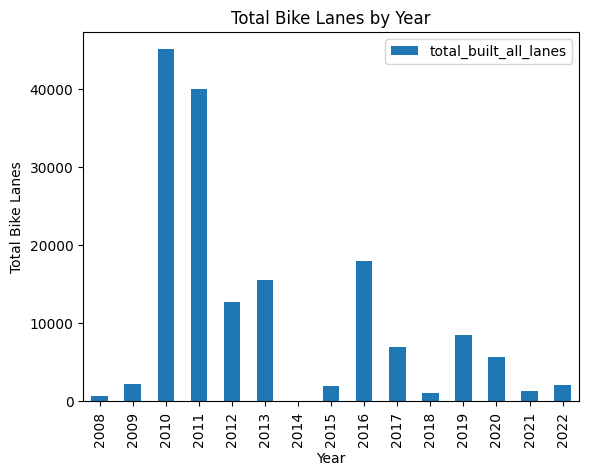

In [118]:
# checking for years with major changes in bike lanes
data = data.loc[data['neighborhood'].isin(['Dorchester', 'Roxbury'])]
data[['year', 'total_built_all_lanes']].groupby('year').sum().plot(kind='bar')
plt.title('Total Bike Lanes by Year')
plt.xlabel('Year')
plt.ylabel('Total Bike Lanes')
plt.show()

In [119]:
target_vars = ['median_monthly_rent', 'median_value', 'race_white', 'median_age', 'mean_income', 'median_income']
target_var_names = ['Median Monthly Rent', 'Median House Value', 'Percent White', 'Median Age', 'Mean Income', 'Median Income']

In [120]:
# add a 'previous years built' columns for 'total_built_all_lanes'
data['previous_1y_built_all_lanes'] = data['total_built_all_lanes'].shift(1)
data['previous_2y_built_all_lanes'] = data['total_built_all_lanes'].shift(2)
data['previous_3y_built_all_lanes'] = data['total_built_all_lanes'].shift(3)
data['previous_4y_built_all_lanes'] = data['total_built_all_lanes'].shift(4)
data['previous_5y_built_all_lanes'] = data['total_built_all_lanes'].shift(5)

possible settings:
1. binary (added bike lanes > 0) vs ordinal (levels of added bike lanes); continuos might be too complicated
2. single year change (fewer observations, more interpretable) vs all years

#### binary DiD: single year, binary treatment

##### 2010

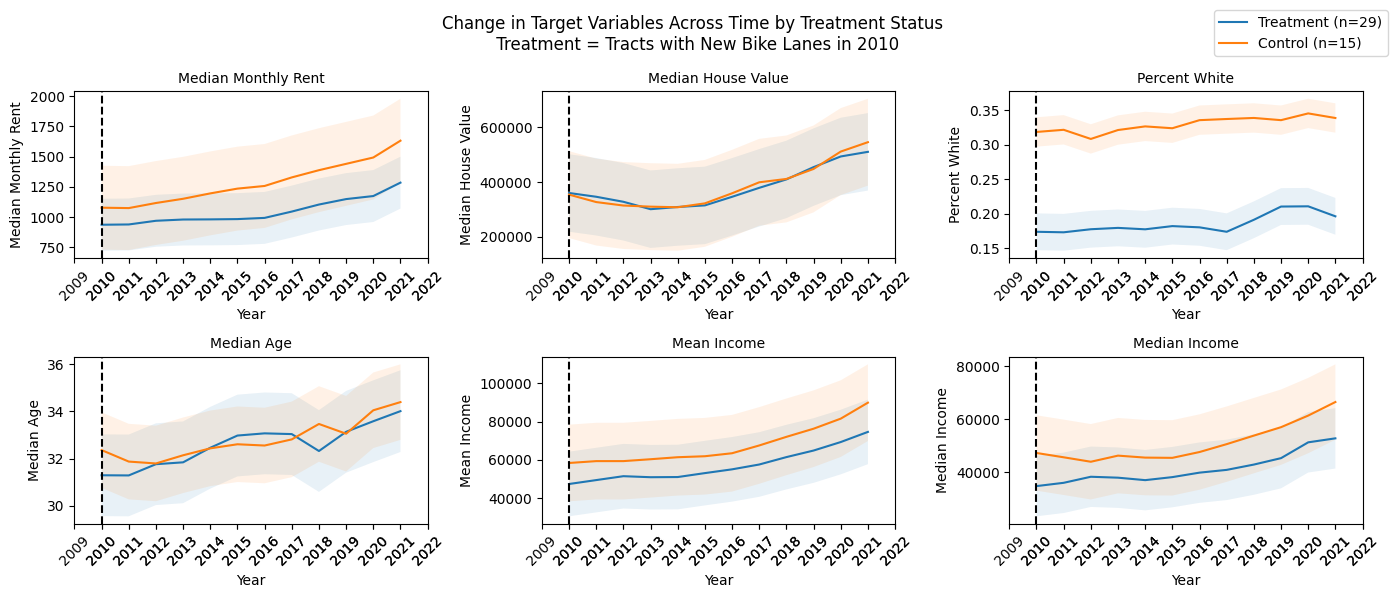

In [124]:
plot_df = data.copy(deep=True)

# create a treatment column to be 1 for all tracts for which 2010 had positive bike addition

# first, identify the tracts that had positive bike addition in 2010
treat_tracts = plot_df[(plot_df['total_built_all_lanes'] > 0)&(plot_df['year']==2010)]['tract'].unique()
# create a treatment column that is 1 for all tracts that had positive bike addition in 2010
plot_df['treatment'] = np.where(plot_df['tract'].isin(treat_tracts), 1, 0)
n_control = plot_df.loc[plot_df['treatment']==0]['tract'].nunique()
n_treatment = plot_df.loc[plot_df['treatment']==1]['tract'].nunique()
#create subplots - number varies by len(target_vars):
cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = plot_df.groupby(['year','treatment'])[var].mean().reset_index()
    treatment = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2010
    ax[i // 3, i %3].plot(treatment['year'], treatment[var], label=f'Treatment (n={n_treatment})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(treatment['year'], treatment[var] - 1.96*treatment[var].std(), treatment[var] + 1.96*treatment[var].std(), alpha=0.1)
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control (n={n_control})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)
    ax[i // 3, i %3].axvline(x=2010, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment = Tracts with New Bike Lanes in 2010')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()

##### 2016

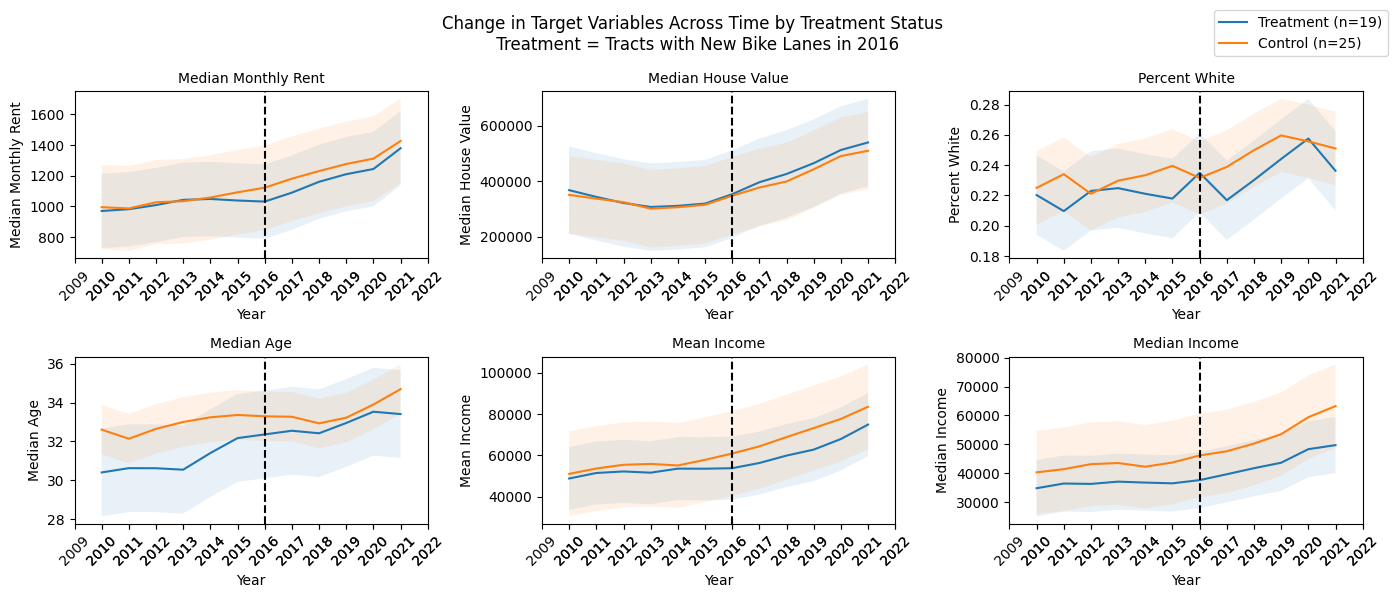

In [125]:
plot_df = data.copy(deep=True)
# create a treatment column to be 1 for all tracts for which 2016 had positive bike addition

# first, identify the tracts that had positive bike addition in 2016
treat_tracts = plot_df[(plot_df['total_built_all_lanes'] > 0)&(plot_df['year']==2016)]['tract'].unique()
# create a treatment column that is 1 for all tracts that had positive bike addition in 2016
plot_df['treatment'] = np.where(plot_df['tract'].isin(treat_tracts), 1, 0)
n_control = plot_df.loc[plot_df['treatment']==0]['tract'].nunique()
n_treatment = plot_df.loc[plot_df['treatment']==1]['tract'].nunique()
#create subplots - number varies by len(target_vars):
cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = plot_df.groupby(['year','treatment'])[var].mean().reset_index()
    treatment = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2016
    ax[i // 3, i %3].plot(treatment['year'], treatment[var], label=f'Treatment (n={n_treatment})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(treatment['year'], treatment[var] - 1.96*treatment[var].std(), treatment[var] + 1.96*treatment[var].std(), alpha=0.1)
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control (n={n_control})')
    # add confidence intervals
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)
    ax[i // 3, i %3].axvline(x=2016, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment = Tracts with New Bike Lanes in 2016')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()

In [133]:
data.columns

Index(['tract', 'year', 'neighborhood', 'total_population', 'male', 'female',
       'median_age', 'race_white', 'race_black', 'race_ai_alaskan',
       'race_asian', 'race_hawaiian', 'race_other', 'race_hispanic',
       'median_value', 'median_monthly_mort', 'median_monthly_rent',
       'median_income', 'mean_income', 'housed_population', 'owner_occupied',
       'owner_occupied_pre-2000', 'renter_occupied',
       'renter_occupied_pre-2000', 'percent_owners', 'percent_renters',
       'percent_owners_pre-2000', 'percent_renters_pre-2000',
       'renters_owners_ratio', 'renters_owners_pre-2000_ratio', 'BFBL', 'BL',
       'BLSL', 'SBL', 'SLM', 'SLMTC', 'SUP', 'total_built_all_lanes',
       'cumulative_length', 'previous_1y_built_all_lanes',
       'previous_2y_built_all_lanes', 'previous_3y_built_all_lanes',
       'previous_4y_built_all_lanes', 'previous_5y_built_all_lanes'],
      dtype='object')

In [158]:
# Run the DiD model
pd.options.display.float_format = '{:.2f}'.format
import statsmodels.formula.api as smf
# add 'post_treatment' column to indicate whether the year is after the treatment year
plot_df['post_treatment'] = np.where(plot_df['year']>=2016, 1, 0)
#filter plot_df for only 5 years before and after treatment
plot_df = plot_df[(plot_df['year']>=2011)&(plot_df['year']<=2021)]
targets = ['median_income', 'median_value', 'median_monthly_rent']
for var in targets:
    model = smf.ols(f'{var} ~ treatment*post_treatment + C(tract) + year + total_population + race_white', data=plot_df).fit()

    #show the summary and exclude the tract variables because there are too many
    table = pd.DataFrame(model.summary2().tables[1])
    # show full numbers instead of scientific notation
    print(var)
    print(table.iloc[-6:])


median_income
                            Coef.  Std.Err.     t  P>|t|   [0.025   0.975]
treatment                 5022.42   1594.05  3.15   0.00  1889.39  8155.44
post_treatment           -1281.79   1475.12 -0.87   0.39 -4181.05  1617.48
treatment:post_treatment -1478.63    813.14 -1.82   0.07 -3076.81   119.55
year                      1989.73    221.44  8.99   0.00  1554.51  2424.96
total_population            -0.35      1.17 -0.30   0.76    -2.65     1.95
race_white               19233.09   9481.74  2.03   0.04   597.26 37868.92
median_value
                             Coef.  Std.Err.     t  P>|t|    [0.025    0.975]
treatment                 10584.82  13353.41  0.79   0.43 -15663.03  36832.66
post_treatment             5214.14  11919.69  0.44   0.66 -18215.54  28643.81
treatment:post_treatment   3667.39   6706.91  0.55   0.58  -9515.91  16850.68
year                      21043.89   1852.71 11.36   0.00  17402.14  24685.64
total_population            -28.72     10.64 -2.70   0.01 

#### Ordinal Treatment: single year, different level treatment

##### 2010

<Axes: >

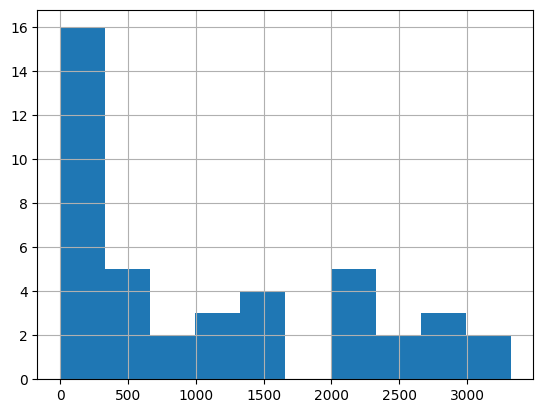

In [127]:
data[data['year']==2010]['total_built_all_lanes'].hist(bins=10)

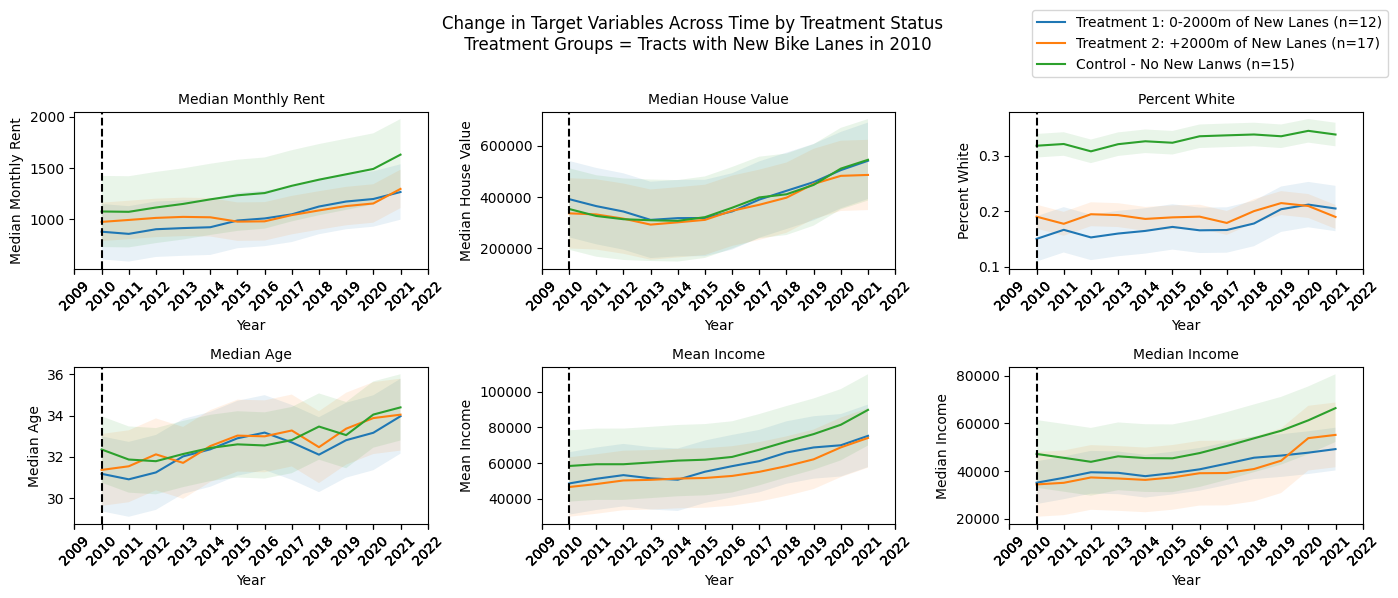

In [128]:
plot_df = data.copy(deep=True)
# create 2 treatment columns for all tracts for which 2010 had positive bike addition: 1 for <2000 and 2 for >=2000

# first, identify the tracts that had positive bike addition in 2010
treat2_tracts = plot_df[(plot_df['total_built_all_lanes'] > 0)&(plot_df['total_built_all_lanes'] <2000)&(plot_df['year']==2010)]['tract'].unique()
treat1_tracts = plot_df[(plot_df['total_built_all_lanes'] >= 2000)&(plot_df['year']==2010)]['tract'].unique()

# create a treatment column that is 1 for all tracts that had positive bike addition in 2010
conditions = [
    plot_df['tract'].isin(treat1_tracts),
    plot_df['tract'].isin(treat2_tracts)
]

choices = [1, 2]
plot_df['treatment'] = np.select(conditions, choices, default=0)
n_control = plot_df.loc[plot_df['treatment']==0]['tract'].nunique()
n_treatment1 = plot_df.loc[plot_df['treatment']==1]['tract'].nunique()
n_treatment2 = plot_df.loc[plot_df['treatment']==2]['tract'].nunique()

cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = plot_df.groupby(['year','treatment'])[var].mean().reset_index()
    treatment2 = target_var_df[target_var_df['treatment'] == 2]
    treatment1 = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2010
    ax[i // 3, i %3].plot(treatment1['year'], treatment1[var], label=f'Treatment 1: 0-2000m of New Lanes (n={n_treatment1})')
    ax[i // 3, i %3].fill_between(treatment1['year'], treatment1[var] - 1.96*treatment1[var].std(), treatment1[var] + 1.96*treatment1[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(treatment2['year'], treatment2[var], label=f'Treatment 2: +2000m of New Lanes (n={n_treatment2})')
    ax[i // 3, i %3].fill_between(treatment2['year'], treatment2[var] - 1.96*treatment2[var].std(), treatment2[var] + 1.96*treatment2[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control - No New Lanws (n={n_control})')
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)

    ax[i // 3, i %3].axvline(x=2010, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment Groups = Tracts with New Bike Lanes in 2010\n')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()

##### 2016

<Axes: >

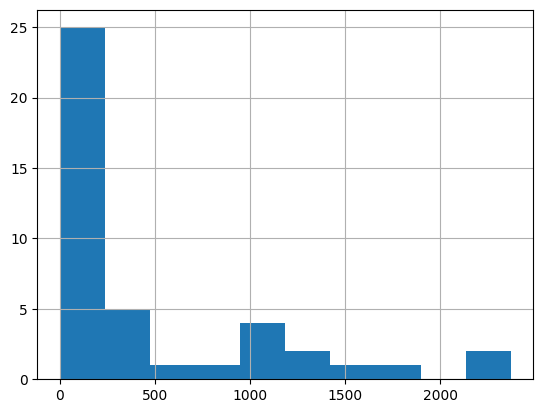

In [129]:
data[data['year']==2016]['total_built_all_lanes'].hist()

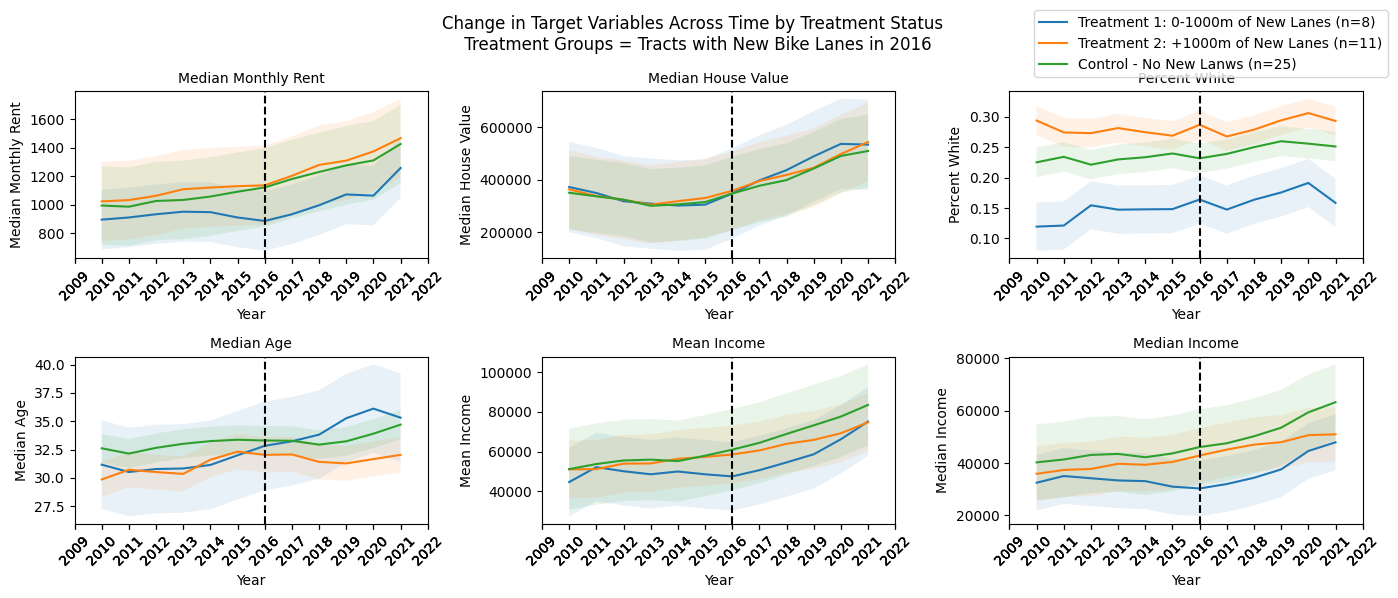

In [130]:
plot_df = data.copy(deep=True)

# create 2 treatment columns for all tracts for which 2016 had positive bike addition: 1 for <1000 and 2 for >=1000

# first, identify the tracts that had positive bike addition in 2016
treat2_tracts = plot_df[(plot_df['total_built_all_lanes'] > 0)&(plot_df['total_built_all_lanes'] <1000)&(plot_df['year']==2016)]['tract'].unique()
treat1_tracts = plot_df[(plot_df['total_built_all_lanes'] >= 1000)&(plot_df['year']==2016)]['tract'].unique()

# create a treatment column that is 1 for all tracts that had positive bike addition in 2016
conditions = [
    plot_df['tract'].isin(treat1_tracts),
    plot_df['tract'].isin(treat2_tracts)
]

choices = [1, 2]
plot_df['treatment'] = np.select(conditions, choices, default=0)
n_control = plot_df.loc[plot_df['treatment']==0]['tract'].nunique()
n_treatment1 = plot_df.loc[plot_df['treatment']==1]['tract'].nunique()
n_treatment2 = plot_df.loc[plot_df['treatment']==2]['tract'].nunique()

cols = 3
rows = len(target_vars)//3
fig, ax = plt.subplots(nrows = rows, ncols = 3, figsize=(14,len(target_vars)))
fontsize = 10  # Set the fontsize here

for i, var in enumerate(target_vars):
    var_name = target_var_names[i]
    # compare the mean of the target variable between treatment and control group across all years
    target_var_df = plot_df.groupby(['year','treatment'])[var].mean().reset_index()
    treatment2 = target_var_df[target_var_df['treatment'] == 2]
    treatment1 = target_var_df[target_var_df['treatment'] == 1]
    control = target_var_df[target_var_df['treatment'] == 0]

    # plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2016
    ax[i // 3, i %3].plot(treatment1['year'], treatment1[var], label=f'Treatment 1: 0-1000m of New Lanes (n={n_treatment1})')
    ax[i // 3, i %3].fill_between(treatment1['year'], treatment1[var] - 1.96*treatment1[var].std(), treatment1[var] + 1.96*treatment1[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(treatment2['year'], treatment2[var], label=f'Treatment 2: +1000m of New Lanes (n={n_treatment2})')
    ax[i // 3, i %3].fill_between(treatment2['year'], treatment2[var] - 1.96*treatment2[var].std(), treatment2[var] + 1.96*treatment2[var].std(), alpha=0.1)
    
    ax[i // 3, i %3].plot(control['year'], control[var], label=f'Control - No New Lanws (n={n_control})')
    ax[i // 3, i %3].fill_between(control['year'], control[var] - 1.96*control[var].std(), control[var] + 1.96*control[var].std(), alpha=0.1)

    ax[i // 3, i %3].axvline(x=2016, color='black', linestyle='--')
    ax[i // 3, i %3].set_title(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].set_xlabel('Year', fontsize=fontsize)
    ax[i // 3, i % 3].set_xticks(target_var_df['year'][3::])
    ax[i // 3, i % 3].set_xticklabels(target_var_df['year'][3::], rotation=45)
    ax[i // 3, i %3].set_ylabel(f'{var_name}', fontsize=fontsize) 
    ax[i // 3, i %3].tick_params(axis='both', labelsize=fontsize)  # Set the fontsize for tick labels

# Create a single legend for the entire figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.suptitle('Change in Target Variables Across Time by Treatment Status \n Treatment Groups = Tracts with New Bike Lanes in 2016')
# plt.text(0.5, 0.9, 'Solid Lines = Tract Group Mean Value; Shaded Areas = 95% Confidence Interval', fontsize=6)
plt.tight_layout()
plt.show()